# Mantenimiento Predictivo con AutoEncoder

Notebook base para dataset CWRU sin optimizar para FPGA ni cuantizacion.

## Introduccion

Se utiliza el dataset de CWRU el cual es apoyado cientificamente con varios papers de respaldo. Para el analisis se utilizan los datos de Drive End (DE) que es el acelerometro mas cercano al eje. Los mismos son obtenidos a una frecuencia de 48KHz y con una carga de 1HP. 

Hay mas datos disponibles pero no son utilizados para este analisis ya que se busca evaluar la clasificacion de N fallas bajo ciertas condiciones. 

Las fallas evaluadas son:

* C1  : Ball defect (0.007 inch, carga: 1 hp)
* C2  : Ball defect (0.014 inch, carga: 1 hp)
* C3  : Ball defect (0.021 inch, carga: 1 hp)
* C4  : Inner race fault (0.007 inch, carga: 1 hp)
* C5  : Inner race fault (0.014 inch, carga: 1 hp)
* C6  : Inner race fault (0.021 inch, carga: 1 hp)
* C7  : Normal (carga: 1 hp)
* C8  : Outer race fault (0.007 inch, carga: 1 hp, 6 O'clock)
* C9  : Outer race fault (0.014 inch, carga: 1 hp, 6 O'clock)
* C10 : Outer race fault (0.021 inch, carga: 1 hp, 6 O'clock)


Cada categoria se toman 1024 puntos de medicion y un total de 460 samples formando un total de datos de (4600, 1024)

## Carga de Datos

In [8]:
import os, time

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # elimino warnings de tensorflow-gpu

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from callbacks import all_callbacks

import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)  # suppress warnings
tf.get_logger().setLevel('ERROR')

from pathlib import Path

In [9]:
file = np.load('./data/CWRU_48k_load_1_CNN_data.npz')  # Numpy Array

data = file['data'].reshape(len(file['data']), 1024)
labels = file['labels']
print(data.shape, labels.shape)
#(4600, 1024) (4600,)

# Labels utilizados
category_labels = np.unique(labels)
print("Labels", category_labels)

# Paso labels a categorias por no poder usar strings
labels = pd.Categorical(labels, categories = category_labels).codes
print("Labels", labels)

# Separo mis datos en 80/20
# Train: 4600*0.8 = 3680
# Test: 4600*0.2 = 920

train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size = int(data.shape[0]*0.2), random_state = 100, 
                                                                    stratify = labels)

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

print(train_data.shape, train_labels.shape, test_data.shape, test_labels.shape )
#(3680, 1024) (3680,) (920, 1024) (920,)

(4600, 1024) (4600,)
Labels ['Ball_007' 'Ball_014' 'Ball_021' 'IR_007' 'IR_014' 'IR_021' 'Normal'
 'OR_007' 'OR_014' 'OR_021']
Labels [0 0 0 ... 6 6 6]
(3680, 1024) (3680, 10) (920, 1024) (920, 10)


## Modelo - Autoencoder

Paper: A novel deep autoencoder feature learning method for rotating machinery fault diagnosis
Shao Haidong, Jiang Hongkai ⇑, Zhao Huiwei, Wang Fuan

Algunas configuraciones del modelo usado en el paper no se pudieron reproducir. 
El paper arma una red de 512/300/150/50/5 pero daba baja efectividad. Con el metodo propuesto se logra mejor efectividad que intentando reproducir el experimento. Igual asi es mas bajo que otros metodos encontrados en otros papers.

Dado que cada modelo es no deterministico, entreno varios modelos y me quedo con el mejor

In [ ]:
#https://github.com/YisenWang/symmetric_cross_entropy_for_noisy_labels
#Para comparacion
def symmetric_cross_entropy(alpha=1, beta=1):
    """
    Symmetric Cross Entropy: 
    ICCV2019 "Symmetric Cross Entropy for Robust Learning with Noisy Labels" 
    https://arxiv.org/abs/1908.06112
    """
    def loss(y_true, y_pred):
        y_true_1 = y_true
        y_pred_1 = y_pred

        y_true_2 = y_true
        y_pred_2 = y_pred

        y_pred_1 = tf.clip_by_value(y_pred_1, 1e-7, 1.0)
        y_true_2 = tf.clip_by_value(y_true_2, 1e-4, 1.0)

        return alpha*tf.reduce_mean(-tf.reduce_sum(y_true_1 * tf.math.log(y_pred_1), axis = -1)) + beta*tf.reduce_mean(-tf.reduce_sum(y_pred_2 * tf.math.log(y_true_2), axis = -1))
    return loss

### Uso de GridSearch para parametros de la red


In [37]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score
from keras.wrappers.scikit_learn import KerasClassifier
import time

import dill as pickle

batch_size = 45
epochs = 200

model = KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=batch_size, verbose=0)

shape = [[512, 100]]
loss_func = ["mean_squared_error", "categorical_crossentropy", symmetric_cross_entropy(), ]

param_grid = dict(loss_func=loss_func)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5, verbose=1)

import joblib
import sys
sys.modules['sklearn.externals.joblib'] = joblib

import time
start_time = time.time()

with sklearn.utils.parallel_backend('threading'):
  grid_result = grid.fit(train_data, train_labels)

print("--- %s seconds ---" % (time.time() - start_time))

#grid_result = grid.fit(train_data, train_labels)

# summarize results
print("Best: %f using %s\n" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("Mean = %f (std=%f) with: %r" % (mean, stdev, param))
    
    
"""
Fitting 5 folds for each of 2 candidates, totalling 10 fits
--- 608.4245464801788 seconds ---
Best: 0.897011 using {'shape': [512, 100]}

Mean = 0.897011 (std=0.014078) with: {'shape': [512, 100]}
Mean = 0.772554 (std=0.031615) with: {'shape': [750, 500, 250]}"""

Fitting 5 folds for each of 3 candidates, totalling 15 fits


/home/wozniak/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/wozniak/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/wozniak/.local/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 219, in fit
    return super(KerasClassifier, self).fit(x, y, **kwargs)
  File "/home/wozniak/.local/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 162, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/home/wozniak/.local/lib/python3.8/site-packages/keras/engine/training.py", line 1184, in fit
    tmp_logs = self.train_function(iterator)
  File "/home/wozniak/.local/lib/python3.8/site-packages/tensorflow/python/eager/def_function.py",

/home/wozniak/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/wozniak/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/wozniak/.local/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 219, in fit
    return super(KerasClassifier, self).fit(x, y, **kwargs)
  File "/home/wozniak/.local/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 162, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/home/wozniak/.local/lib/python3.8/site-packages/keras/engine/training.py", line 1184, in fit
    tmp_logs = self.train_function(iterator)
  File "/home/wozniak/.local/lib/python3.8/site-packages/tensorflow/python/eager/def_function.py",

KeyboardInterrupt: 

## Comienzo Entrenamiento

In [52]:
import datetime

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

from callbacks import all_callbacks

callbacks = all_callbacks(stop_patience = 1000,
                        lr_factor = 0.5,
                        lr_patience = 10,
                        lr_epsilon = 0.000001,
                        lr_cooldown = 2,
                        lr_minimum = 0.0000001,
                        outputDir = 'output_folder_train')

### Diseño de Correntropia

Para evitar problemas con variables se utilizan inputs de TF

In [228]:
import tensorflow as tf

tf_2pi = tf.constant(tf.sqrt(2*np.pi), dtype=tf.float32)


@tf.function
def mercer_kernel(x, sigma=3.31):
    return (1 / (tf_2pi * sigma)) * tf.exp((-(x * x) / (2 * sigma * sigma)))

@tf.function
def correntropy(y_true, y_pred):
    return -tf.math.reduce_mean(mercer_kernel(y_true - y_pred))

### Sparsity Regularizer

In [259]:
from keras import backend as K

def kl_divergence(rho, rho_hat):
    return rho * tf.math.log(rho) - rho * tf.math.log(rho_hat) + (1 - rho) * tf.math.log(1 - rho) - (1 - rho) * tf.math.log(1 - rho_hat)

# Gaussian kernel size of autoencoder r = 2.286 (Given by AFSA)
# Weight of the sparsity penalty term of autoencoder b=0.017 (Given by AFSA)
# Sparsity parameter of autoencoder q = 0.015

class SparseRegularizer(keras.regularizers.Regularizer):

    def __init__(self, p=0.1, sparsityBeta=3):
        self.p = p
        self.sparsityBeta = sparsityBeta

    def __call__(self, x):
        regularization = 0            

        p_hat = K.mean(x, axis=0)
        regularization += self.sparsityBeta * K.sum(kl_divergence(self.p, p_hat))

        return regularization

    def get_config(self):
        return {"name": self.__class__.__name__} 
    
regularizer = SparseRegularizer(0.015, 0.017)

### Weight Regularizer

In [268]:
# Weight decay parameter of autoencoder k  4.736 (Given by AFSA)

class WeightDecayRegularizer(keras.regularizers.Regularizer):

    def __init__(self, strength):
        self.strength = strength

    def __call__(self, x):
        return self.strength * tf.reduce_sum(tf.square(x))
    
    def get_config(self):
        return {'strength': self.strength}
    
weight_regularizer = WeightRegularizer(4.736)

In [266]:
# Defino autoencoder   https://blog.keras.io/building-autoencoders-in-keras.html
# 512/300/150/50/5 Paper
# learning_rate = 0.1 - ok
# momentum = 0.85 - ok
# iteration_times = 60 - ok entreno 200 

# Gaussian kernel size of autoencoder r = 2.286 (Given by AFSA)
# Weight of the sparsity penalty term of autoencoder b=0.017 (Given by AFSA)
# Sparsity parameter of autoencoder q = 0.015
# Weight decay parameter of autoencoder k  4.736 (Given by AFSA)
# The number of the fish swarm of AFSA  L  7
# The fish visual range of AFSA  Visual 6
# The trying number of foraging behavior of AFSA try_number  2
# The maximum generation number of AFSA Maxgen  20
# The crowd factor of AFSA  d = 0.618

from tensorflow.keras.regularizers import l1, l2

act_func = 'relu'
out_func = 'softmax'
k_inic = 'glorot_uniform'  # Inicializo los pesos aleatorios https://machinelearningmastery.com/why-initialize-a-neural-network-with-random-weights/

def create_model(shape=[512, 100], loss_func='mse'):
    # Entrada
    # shape = [512, 100] out siempre 10 en este caso
    
    model = Sequential()

    for shape_size in shape:
        model.add(Dense(shape_size, activation=act_func, kernel_initializer=k_inic, kernel_regularizer=weight_regularizer))

    # Capa de salida
    model.add(Dense(10, activation=out_func, kernel_initializer=k_inic, kernel_regularizer=weight_regularizer))

    optimizer = keras.optimizers.Adam()
    # optimizer = keras.optimizers.SGD(lr=0.1, momentum=0.9) #Paper no especifica, se cambia Adam por SGD con los datos provistos
    
    model.compile(loss=loss_func, optimizer=optimizer, metrics=["accuracy"])
    model.build(input_shape=(None, 1024))

    return model

### AFSA - Artificial Fish Swarm Optimization

| input parameters | default value | paper value |                     meaning                    |   |
|------------------|:-------------:|-------------|:----------------------------------------------:|---|
| func             | -             |             | objective function                             |   |
| n_dim            | -             |             | dim of objective function                      |   |
| size_pop         | 50            | 7           | size of population                             |   |
| max_iter         | 300           | 20          | max iteration                                  |   |
| max_try_num      | 100           | 2           | max try of prey in one movement                |   |
| step             | 0.5           | -           | max scale of movement                          |   |
| visual           | 0.3           | 6           | max range of perception                        |   |
| q                | 0.98          | -            | perception of fish will go down every movement |   |
| delta            | 0.5           | 0.618       | fishes toleration of crowd                     |   |
    


In [242]:
from sko.AFSA import AFSA

# Gaussian kernel size of autoencoder r = 2.286 (Given by AFSA)
# Weight of the sparsity penalty term of autoencoder b=0.017 (Given by AFSA)
# Sparsity parameter of autoencoder q = 0.015
# Weight decay parameter of autoencoder k  4.736 (Given by AFSA)
# The number of the fish swarm of AFSA  L  7
# The fish visual range of AFSA  Visual 6
# The trying number of foraging behavior of AFSA try_number  2
# The maximum generation number of AFSA Maxgen  20
# The crowd factor of AFSA  d = 0.618

def correntropy_afsa(x):
    y_true, y_pred, sigma = x
    y_true = y_true.astype(np.float32)
    y_pred = y_pred.astype(np.float32)
    sigma = sigma.astype(np.float32)
    return -tf.math.reduce_mean(mercer_kernel(y_true - y_pred, sigma=sigma))

def func(x):
    x1, x2 = x
    return 1 / x1 ** 2 + x1 ** 2 + 1 / x2 ** 2 + x2 ** 2


# #Default
# afsa = AFSA(func, n_dim=2, size_pop=50, max_iter=20,
#             max_try_num=100, step=0.5, visual=0.3,
#             q=0.98, delta=0.5)

# Paper
afsa = AFSA(correntropy_afsa, n_dim=3, size_pop=7, max_iter=20,
            max_try_num=2, step=0.5, visual=6,
            q=0.98, delta=0.618)


best_x, best_y = afsa.run()

print(best_x, best_y)

[0.44705101 0.33455937 0.30466603] -0.4651434


### Entreno Moelo

In [270]:
TOTAL_MODELS = 5  # Entreno 5 veces
res = np.empty(TOTAL_MODELS)
res[:] = np.nan
max_res = 0
BATCH_SIZE = 45
EPOCHS = 60  # Entrena por 60 pero dejo 200
VALIDATION_SPLIT = 0.05  # Cantidad de datos que uso para validar entre epochs

print("Comienzo Entrenamiento")

model = create_model(shape=[512, 100])
model.summary()

mean_fit_time = 0
mean_fit_acc = 0

for i in range(5):
    start_time = time.time()
    model = create_model(shape=[512, 100], loss_func=correntropy)
    history = model.fit(train_data, train_labels, epochs = EPOCHS, batch_size = BATCH_SIZE, validation_split=VALIDATION_SPLIT, 
                        verbose = 0)
#                         callbacks = callbacks.callbacks, verbose = 0)
    model_time = time.time() - start_time
    res[i] = model.evaluate(test_data, test_labels, batch_size = BATCH_SIZE, verbose = 0)[1]
    print('Iteracion: {}, Accuracy: {:4.4f}, Time: {:2f}'.format(i+1, np.max(res[i]), model_time))

    mean_fit_time += model_time
    mean_fit_acc += np.max(res[i])
    
    if res[i] >= max_res:
        max_res = res[i]
        best_model = model
        best_history = history
        
mean_fit_time /= TOTAL_MODELS
mean_fit_acc /= TOTAL_MODELS
print("Precision Promedio: {:.4f}, Tiempo Promedio: {:.2f}".format(mean_fit_time, mean_fit_acc))

Comienzo Entrenamiento
Model: "sequential_256"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_771 (Dense)            (None, 512)               524800    
_________________________________________________________________
dense_772 (Dense)            (None, 100)               51300     
_________________________________________________________________
dense_773 (Dense)            (None, 10)                1010      
Total params: 577,110
Trainable params: 577,110
Non-trainable params: 0
_________________________________________________________________
Iteracion: 1, Accuracy: 0.1000, Time: 31.350919
Iteracion: 2, Accuracy: 0.1000, Time: 25.467501
Iteracion: 3, Accuracy: 0.1000, Time: 30.530216
Iteracion: 4, Accuracy: 0.1000, Time: 31.105054
Iteracion: 5, Accuracy: 0.1000, Time: 23.424869
Precision Promedio: 28.3757, Tiempo Promedio: 0.10


### Resultados

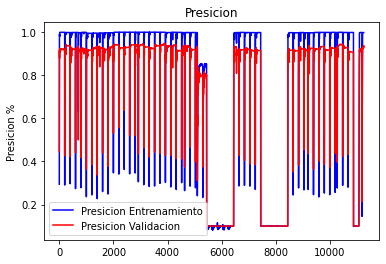

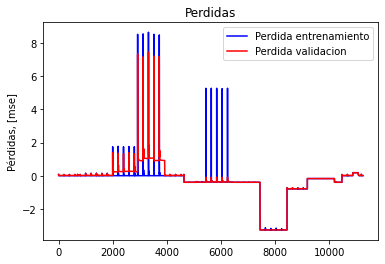

In [216]:
model = best_model
history = best_history

history = history
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'b', label='Presicion Entrenamiento')
plt.plot(epochs, val_accuracy, 'r', label='Presicion Validacion')
plt.title('Presicion')
plt.ylabel('Presicion %')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'b', label='Perdida entrenamiento')
plt.plot(epochs, val_loss, 'r', label='Perdida validacion')
plt.title('Perdidas')
plt.ylabel('Pérdidas, [mse]')

plt.legend()
plt.show()

In [ ]:
# Realizo la prediccion en matriz

prediction = model.predict(test_data)
prediction_labels = list([])
for each_prediction in prediction:
    prediction_labels.append(list(each_prediction).index(max(each_prediction)))
    
# Matriz de Confusion

import seaborn as sns
from sklearn.metrics import confusion_matrix

true_labels = np.argmax(test_labels, axis = 1)
matrix = confusion_matrix(true_labels, prediction_labels)

matrix = pd.DataFrame(matrix)
plt.figure()
sns.heatmap(matrix, annot= True, fmt = "d",
           xticklabels = category_labels,
           yticklabels = category_labels, cmap = "Blues", cbar = False)
plt.xticks(rotation = 90)
plt.show()

In [ ]:
import random

single_data = random.choice(test_data)
single_data = (np.expand_dims(single_data,0))  # Ajusto el formato del dato

# Hago promedio de 100 prediciones para ver los tiempos en cpu
best_time = 1
worst_time = 0
mean_time = 0
TOTAL_LOOPS = 100

for _ in range(TOTAL_LOOPS):
    start_time = time.time()
    predictions_single = model.predict(single_data)  # Prediccion
    end_time = time.time() - start_time
    if end_time < best_time:
        best_time = end_time
    if end_time > worst_time:
        worst_time = end_time
    mean_time += end_time
mean_time = mean_time/TOTAL_LOOPS

# Paso a ms
mean_time *= 1000
best_time *= 1000
worst_time *= 1000
print('Mean Time: {:2f}, Best Time: {:.2f}, Worst Time: {:.2f}'.format(mean_time, best_time, worst_time))

# Promedio 1000 predicciones en ms
# Mean Time: 31.636208, Best Time: 28.31, Worst Time: 344.13

# Muestro la prediccion
predicted = np.argmax(predictions_single[0])

data_print = single_data.reshape(1024)
plt.figure()
plt.plot(data_print, label="{} {:.2f}%".format(category_labels[predicted], np.max(predictions_single)*100))
plt.legend()